# 解相对论流体

1. 寻找一组变换，使得变换之后能量密度分布均匀各向同性，得到解析解 $u^{\mu}=(1, 0, 0, 0)$。
2. 直接使用 PINN 解一阶粘滞流体力学，然后用 DeepOnet 学习解算子

$$\nabla_{\mu} T^{\mu\nu} = 0,\quad\; T^{\mu\nu} = (\epsilon+P)u^{\mu}u^{\nu} - P g^{\mu\nu} + \pi^{\mu\nu}$$

里面需要解 $\epsilon(t, x, y, z), v_i(t, x, y, z)$, 它需要满足初始条件，可以写为,

$$\epsilon(t, x, y, z) = (t-t_0)\phi_0(t, x, y, z) + \epsilon(t_0, x, y, z),\quad\; v_i(t, x, y, z) = (t-t_0)\phi_i(t, x, y, z)$$



需要满足约束：$ \sum_i v_i^2 \le 1$, 麻烦！

是否能直接解 $T^{0\mu}$? 解出来之后再反推出来 $\epsilon$, P 和 $u^{\mu}$？

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

OSError: libmkl_intel_lp64.so.1: cannot open shared object file: No such file or directory

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
x = np.linspace(-10, 10, 101)
y = np.linspace(-10, 10, 101)
xx, yy = np.meshgrid(x, y)
# width of the gaussian dist
a = 5
ed = 30 * np.exp(-(xx**2 + yy**2) / (2*a**2))
pr = ed / 3.0
vx = np.zeros_like(ed)
vy = np.zeros_like(ed)

In [4]:
def initial_ed(x, y, a=5):
    return 30 * torch.exp(-(x**2 + y**2) / (2 * a**2))

In [5]:
def Tmn(e, p, u, g, m, n):
    '''energy momentum tensor'''
    return (e+p)*u[m]*u[n] - p * g[m, n]

In [6]:
#plt.imshow(ed)
ut = np.ones_like(vx)
ux = ut * vx
uy = ut * vy

u = [ut, ux, uy]

In [7]:
class EDLayer(nn.Module):
    '''能量密度相对初始时刻减小的量'''
    def __init__(self, edmax=30, hidden_size=32):
        super(EDLayer, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
            )
        self.edmax = edmax
        
    def forward(self, xmu):
        return - self.edmax * self.net(xmu)

In [8]:
class VelocityLayer(nn.Module):
    def __init__(self, hidden_size=32):
        super(VelocityLayer, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 2),
            nn.Tanh()
            )
    
    def forward(self, xmu):
        '''return vx, vy, vz'''
        return self.net(xmu)

In [14]:
ed_net = EDLayer().to(device)
xmu = torch.tensor([0.5, 0, 0]).to(device)

ed_net(xmu)

tensor([-14.6103], device='cuda:0', grad_fn=<MulBackward0>)

In [15]:
v_net = VelocityLayer().to(device)
v_net(xmu)

tensor([-0.0243, -0.0961], device='cuda:0', grad_fn=<TanhBackward0>)

In [16]:
nsamples = 1280
coords = np.empty(shape=(nsamples, 3), dtype=np.float32)

coords[:, 0] = np.random.uniform(0.6, 1.2, nsamples)
coords[:, 1:3] = np.random.uniform(-10, 10, (nsamples, 2))

In [17]:
coords[:5]

array([[ 0.7238015 , -5.657441  ,  7.8931804 ],
       [ 0.79972404,  8.662132  ,  2.6736195 ],
       [ 0.8984817 , -3.1663463 , -7.5512915 ],
       [ 1.137556  ,  1.0590013 ,  5.5620117 ],
       [ 0.6437712 ,  4.60704   , -8.114623  ]], dtype=float32)

In [18]:
xmu = torch.tensor(data=coords, requires_grad=True).to(device)

In [19]:
v_net(xmu[:5])

tensor([[-0.0724, -0.1547],
        [-0.0051,  0.0267],
        [-0.0308, -0.0361],
        [ 0.0161, -0.1217],
        [ 0.0411,  0.0654]], device='cuda:0', grad_fn=<TanhBackward0>)

In [20]:
def umu(v):
    # beta2 = v^2
    beta2 = torch.sum(v**2, dim=1) 
    beta2 = torch.where(beta2<1, beta2, 0.999)
    u0 = 1 / (1 - beta2)
    u = torch.zeros((len(v), 3))
    u[:, 0] = u0
    u[:, 1] = u0 * v[:, 0]  # ux
    u[:, 2] = u0 * v[:, 1]  # uy
    return u

In [21]:
g = torch.tensor([[1., 0, 0, 0],
                  [0, -1.,0, 0],
                  [0, 0,-1., 0],
                  [0, 0, 0,-1.],
                 ]).to(device)

In [22]:
def Tmn(e, p, u, g, m, n):
    '''energy momentum tensor'''
    return (e+p)*u[:, m]*u[:, n] - p * g[m, n]

In [26]:
ed = ed_net(xmu)
v2 = v_net(xmu)
pr = ed / 3.0
um = umu(v2).to(device)
Tmn(ed, pr, um, g, 2, 2)

tensor([[-5.7837, -5.2654, -5.2779,  ..., -5.8605, -5.6283, -5.3718],
        [-4.6489, -4.2324, -4.2424,  ..., -4.7107, -4.5241, -4.3178],
        [-6.1650, -5.6125, -5.6258,  ..., -6.2468, -5.9994, -5.7259],
        ...,
        [-6.0645, -5.5211, -5.5342,  ..., -6.1450, -5.9016, -5.6326],
        [-5.5461, -5.0491, -5.0611,  ..., -5.6197, -5.3971, -5.1511],
        [-4.5071, -4.1033, -4.1130,  ..., -4.5670, -4.3861, -4.1861]],
       device='cuda:0', grad_fn=<SubBackward0>)

In [27]:
from torch.autograd import grad

In [28]:
optimizer1 = torch.optim.AdamW(ed_net.parameters(), lr=1.0E-4, weight_decay=0.01)
optimizer2 = torch.optim.AdamW(v_net.parameters(), lr =1.0E-4, weight_decay=0.01)

In [29]:
sss = torch.tensor([3., 4., 5])

sss.reshape(3, 1)

tensor([[3.],
        [4.],
        [5.]])

In [46]:
batch_size = 16
t0 = 0.6
for epoch in range(10):
    for i in range(nsamples // batch_size):
        x_ = xmu[i*batch_size : (i+1)*batch_size, :]
        ed = (x_[:, 0] - t0) * ed_net(x_) 
        ed = ed + torch.reshape(initial_ed(x_[:, 1], x_[:, 2]), shape=(batch_size, 1))
        pr = ed / 3.0
        v_ = torch.reshape(x_[:, 0] - t0, (batch_size, 1)) * v_net(x_)
        um = umu(v_).to(device)
        T00 = Tmn(ed, pr, um, g, 0, 0)
        T01 = Tmn(ed, pr, um, g, 0, 1)
        T02 = Tmn(ed, pr, um, g, 0, 2)
        T11 = Tmn(ed, pr, um, g, 1, 1)
        T12 = Tmn(ed, pr, um, g, 1, 2)
        T22 = Tmn(ed, pr, um, g, 2, 2)
        
        dT00_over_dxmu = grad(T00, x_, create_graph=True, grad_outputs=torch.ones_like(T00),  retain_graph=True)[0]
        dT01_over_dxmu = grad(T01, x_, create_graph=True, grad_outputs=torch.ones_like(T00),  retain_graph=True)[0]
        dT02_over_dxmu = grad(T02, x_, create_graph=True, grad_outputs=torch.ones_like(T00),  retain_graph=True)[0]
        dT11_over_dxmu = grad(T11, x_, create_graph=True, grad_outputs=torch.ones_like(T00),  retain_graph=True)[0]
        dT12_over_dxmu = grad(T12, x_, create_graph=True, grad_outputs=torch.ones_like(T00),  retain_graph=True)[0]
        dT22_over_dxmu = grad(T22, x_, create_graph=True, grad_outputs=torch.ones_like(T00),  retain_graph=True)[0]
        
        eq1 = dT00_over_dxmu[:, 0] + dT01_over_dxmu[:, 1] + dT02_over_dxmu[:, 2]
        eq2 = dT01_over_dxmu[:, 0] + dT11_over_dxmu[:, 1] + dT12_over_dxmu[:, 2]
        eq3 = dT02_over_dxmu[:, 0] + dT12_over_dxmu[:, 1] + dT22_over_dxmu[:, 2]
        loss = torch.mean(eq1**2 + eq2**2 + eq3**2)
        optimizer1.zero_grad()
        optimizer2.zero_grad()
        loss.backward()
        optimizer1.step()
        optimizer2.step()
    print("epoch=%s, loss=%s"%(epoch, loss.data))

epoch=0, loss=tensor(6301.7729, device='cuda:0')
epoch=1, loss=tensor(5173.9932, device='cuda:0')
epoch=2, loss=tensor(4197.9155, device='cuda:0')
epoch=3, loss=tensor(3374.2029, device='cuda:0')
epoch=4, loss=tensor(2696.7551, device='cuda:0')
epoch=5, loss=tensor(2153.0735, device='cuda:0')
epoch=6, loss=tensor(1725.6019, device='cuda:0')
epoch=7, loss=tensor(1394.1128, device='cuda:0')
epoch=8, loss=tensor(1138.4642, device='cuda:0')
epoch=9, loss=tensor(940.8381, device='cuda:0')


In [58]:
def ed_slice(t=0.7, t0=0.6):
    x = np.linspace(-10, 10, 101)
    y = np.linspace(-10, 10, 101)
    xx, yy = np.meshgrid(x, y)
    test_coords = np.zeros((101*101, 3), dtype=np.float32)
    test_coords[:, 0] = t
    test_coords[:, 1] = xx.flatten()
    test_coords[:, 2] = yy.flatten()
    x_ = torch.tensor(test_coords)
    ed = (t - t0) * ed_net(x_)
    ed_ini = initial_ed(x_[:, 1], x_[:, 2])
    return torch.reshape(torch.squeeze(ed) + ed_ini, (101, 101)).detach().numpy()

In [59]:
ed_0p6 = ed_slice(t=0.6)
ed_0p9 = ed_slice(t=0.9)
ed_1p2 = ed_slice(t=1.2)
#ed_.shape
plt.imshow(ed_1p2)
plt.colorbar()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [60]:
def vel_slice(t):
    x = np.linspace(-10, 10, 101)
    y = np.linspace(-10, 10, 101)
    xx, yy = np.meshgrid(x, y)
    test_coords = np.zeros((101*101, 3), dtype=np.float32)
    test_coords[:, 0] = t
    test_coords[:, 1] = xx.flatten()
    test_coords[:, 2] = yy.flatten()
    vxy = v_net(torch.tensor(test_coords))
    
    vx = vxy[:, 0].reshape(101, 101).detach().numpy()
    vy = vxy[:, 1].reshape(101, 101).detach().numpy()
    
    plt.subplot(121)
    plt.imshow(vx, origin='lower')
    plt.colorbar()
       
    plt.subplot(122)
    plt.imshow(vy, origin='lower')
    plt.colorbar()

In [61]:
vel_slice(t=4.2)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

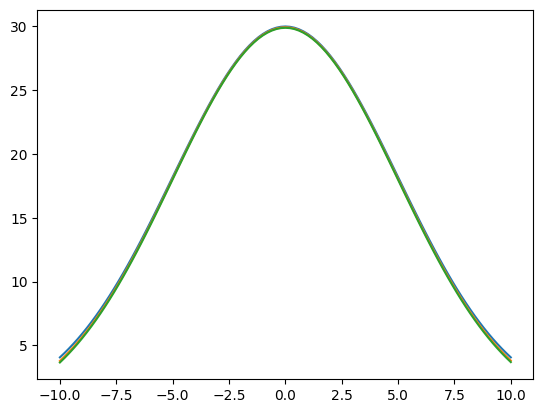

In [71]:
x = np.linspace(-10, 10, 101)
plt.plot(x, ed_0p6[50, :])
plt.plot(x, ed_0p9[50, :])
plt.plot(x, ed_1p2[50, :])

In [72]:
xmu = torch.zeros((101, 3))
xmu[:, 0] = 1.0
xmu[:, 1] = torch.linspace(-10, 10, 101)
xmu[:, 2] = 0
vxy = v_net(xmu)

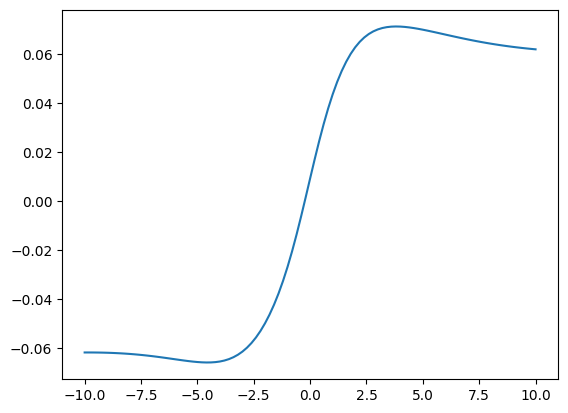

In [73]:
vx = vxy[:, 0]
x = np.linspace(-10, 10, 101)
plt.plot(x, vx.detach().numpy())

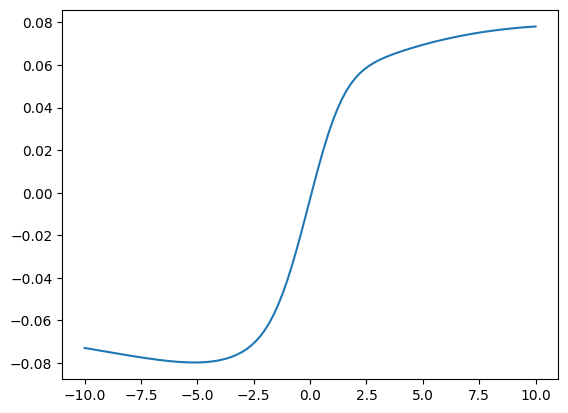

In [74]:
xmu = torch.zeros((101, 3))
xmu[:, 0] = 1.2
xmu[:, 1] = 0
xmu[:, 2] = torch.linspace(-10, 10, 101)
vxy = v_net(xmu)
vy = vxy[:, 1]
x = np.linspace(-10, 10, 101)
plt.plot(x, vy.detach().numpy())